In [1]:
import math
import numpy as np
import gc
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import  StratifiedKFold

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [70]:
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

### Exploratory Data Analysis(EDA)

In [55]:
X_train['Survived'].value_counts()


0    549
1    342
Name: Survived, dtype: int64

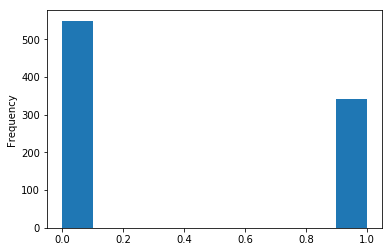

In [56]:
X_train['Survived'].astype(int).plot.hist();


From this information, we see this is an balanced class problem.

### Examine Missing Values


In [57]:
def missing_values_table(df):
    
    print ("Total Records : ",df.shape[0])
    
    # Get Null rows count 
    df_null_values = df.isnull().sum()
    
    # Get Null percentage 
    df_null_perc = (100 * df_null_values) / df.shape[0]
    
    df_nan = pd.DataFrame({'# NaN Rows': df_null_values, '% NaN Rows': df_null_perc})
    
    print(df_nan.sort_values(by=['# NaN Rows'], ascending=False))
    
    

In [58]:
missing_values_table(X_train)

Total Records :  891
             # NaN Rows  % NaN Rows
Cabin               687   77.104377
Age                 177   19.865320
Embarked              2    0.224467
PassengerId           0    0.000000
Survived              0    0.000000
Pclass                0    0.000000
Name                  0    0.000000
Sex                   0    0.000000
SibSp                 0    0.000000
Parch                 0    0.000000
Ticket                0    0.000000
Fare                  0    0.000000


Multiple ways to handle missing values 

1. Remove columns having null values more than 70%
2. Impute values 

In [61]:
X_train[X_train['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


### Column Types

In [62]:
X_train.dtypes.value_counts()


object     5
int64      5
float64    2
dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.



In [63]:
X_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

From this information, we see NAME, TICKET and CABIN have relatively larger set of values. So we will ignore these columns. 

### Encoding Categorical Data

There are two main ways to carry out this process:

1. Label Encoding 

2. One-hot encoding 

We will do Label encoding for Sex and Embarked features. 

In [64]:
def label_encode_column(df, col_name):
    df[col_name] = pd.Categorical(df[col_name])
    df[col_name+'_le'] = df[col_name].cat.codes
    df = df.drop(col_name,axis=1)
    return df

In [65]:
def encode_categorical_features(df):
    df = label_encode_column(df, 'Sex')
    df = label_encode_column(df, 'Embarked')
    return df
    

In [66]:
def remove_unrequired_cat_features(df):
    df = df.drop(['Name','Cabin','Ticket','PassengerId'],axis=1)
    return df

### Back to EDA

In [14]:
def kde_plt(df):
    plt.figure(figsize = (10, 20))
    # iterate through the new features
    for i, feature in enumerate(list(df)):
       
        if feature == 'Survived':
            continue
    
        # create a new subplot for each source
        plt.subplot(8, 1, i + 1)
        # plot survived passengers
        sns.kdeplot(df.loc[df['Survived'] == 1, feature], label = 'Survived == 1')
        # plot not survived passengers
        sns.kdeplot(df.loc[df['Survived'] == 0, feature], label = 'Survived == 0')

        # Label the plots
        plt.title('survival rate by %s ' % feature)
        plt.xlabel('%s' % feature); plt.ylabel('Density');
    
    plt.tight_layout(h_pad = 2.5)

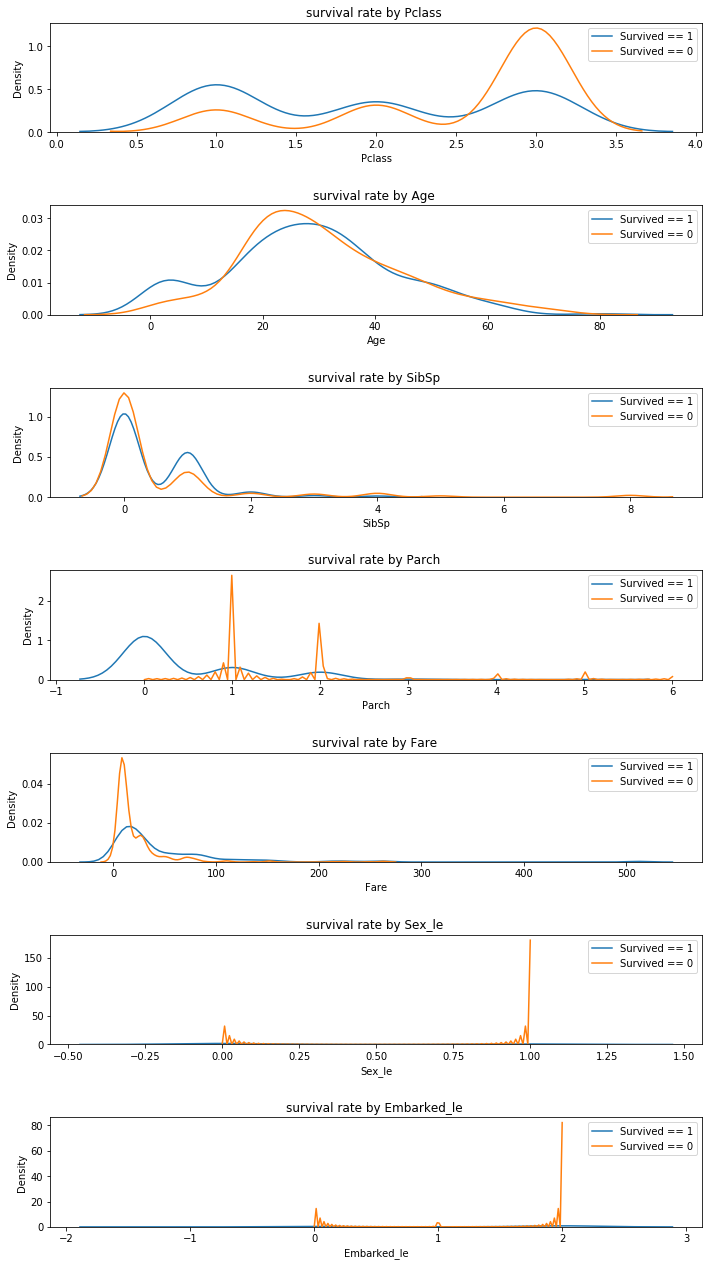

In [15]:
kde_plt(X_train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1))

*Observations*

1. Most of passengers died when Pclass = 3. 
2. Survival Rate is high when Age < ~10. (Around 10)
3. Survival Rate is less when SibSp =0. 
4. Survival Rate is less when Parch =1.
5. As Fare increases, Survival Rate increases. 
6. Survival Rate is high for Females compared to Male. 
7. Survival Rate is less for Embark = 2. 

Now we understand our data in much better way.

### Corelations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate  correlation coefficient between every variable and the target using the .corr dataframe method.



In [34]:
X_train.corr()['Survived'].abs().sort_values(ascending=False)


Survived           1.000000
Sex_le             0.543351
Pclass             0.338481
Fare               0.257307
alone              0.203367
Embarked_le        0.176509
Age_less_than_8    0.147719
Parch              0.081629
Age                0.077221
SibSp              0.035322
Name: Survived, dtype: float64

### Feature Engineering

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods:

1. Highly corelated features
2. Domain knowledge features


Let's create Domain knowledge features now. 

In [35]:
# if age is less, then most likely passenger will survive. 
def f(parch, sibsp):
    if parch == 0 and sibsp == 0:
        return 1
    else:
        return 0

def add_domain_features(df):
    df['Age_less_than_8'] = df['Age'].apply(lambda x: 1 if x <= 8 else 0)
    df['alone'] = df.apply(lambda x: f(x.Parch, x.SibSp), axis = 1)
    return df

### Putting all together for pre- processing data

In [72]:
def preprocess_data(df): 
    
    df = encode_categorical_features(df)
    df = add_domain_features(df)
    df = remove_unrequired_cat_features(df)
    df["Age"].fillna(df["Age"].median(skipna=True), inplace=True)
    df["Fare"].fillna(0, inplace=True)
    
    return df
    

### Logistic Regression Model

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# create X_train (features) and y (response)
X_train = pd.read_csv('train.csv')

X_test = pd.read_csv('test.csv')
    
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)


# train logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train.drop(['Survived'],axis=1),X_train[['Survived']])
y_pred = logreg.predict(X_test)


/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [74]:
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,